<a href="https://colab.research.google.com/github/LaouaMERiLO/Canny_Image_Edge_Detection/blob/main/Image_Edge_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries


In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Canny edge detection

As a human, our brain has no problem detecting edges in any image, but to automate the task on computers we have to use programs that can do the task. One widely used technique for edge detection in images is the Canny edge detection algorithm. This technique is based on the ability to identify significant changes in intensity within an image, which typically correspond to object boundaries or edges. It accomplishes this through a sequence of key steps:

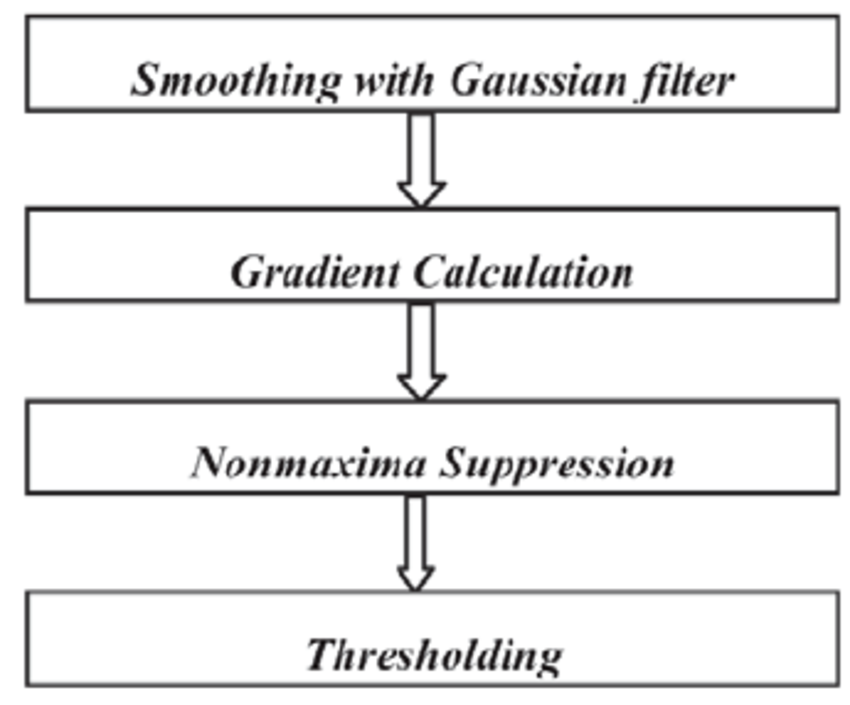














In [23]:
def convolution(image: np.ndarray, kernel: list | tuple) -> np.ndarray:

    if len(image.shape) == 3:
        m_i, n_i, c_i = image.shape

    # if the image is gray then we won't be having an extra channel so handling it
    elif len(image.shape) == 2:
        image = image[..., np.newaxis]
        m_i, n_i, c_i = image.shape
    else:
        raise Exception('Shape of image not supported')

    m_k, n_k = kernel.shape

    y_strides = m_i - m_k + 1  # possible number of strides in y direction
    x_strides = n_i - n_k + 1  # possible number of strides in x direction

    img = image.copy()
    output_shape = (m_i-m_k+1, n_i-n_k+1, c_i)
    output = np.zeros(output_shape, dtype=np.float32)

    count = 0  # taking count of the convolution operation being happening

    output_tmp = output.reshape(
        (output_shape[0]*output_shape[1], output_shape[2])
    )

    for i in range(y_strides):
        for j in range(x_strides):
            for c in range(c_i):
                sub_matrix = img[i:i+m_k, j:j+n_k, c]

                output_tmp[count, c] = np.sum(sub_matrix * kernel)

            count += 1

    output = output_tmp.reshape(output_shape)

    return output


##1. **Gray scale conversion**:
 converting a colored image into a grayscale image

In [25]:
def togray(img: np.ndarray, format: str):
    '''
    Algorithm:
    >>> 0.2989 * R + 0.5870 * G + 0.1140 * B

    - Returns a gray image
    '''
    if format.lower() == 'bgr':
        b, g, r = img[..., 0], img[..., 1], img[..., 2]
        return 0.2989 * r + 0.5870 * g + 0.1140 * b
    elif format.lower() == 'rgb':
        r, g, b = img[..., 0], img[..., 1], img[..., 2]
        return 0.2989 * r + 0.5870 * g + 0.1140 * b
    else:
        raise Exception('Unsupported value in parameter \'format\'')

##2. Noise reduction:
Noise reduction aims to eliminate or reduce random variations in pixel values that might obscure actual edges. using Gaussian smoothing

In [24]:
def gaussianBlur(img: np.ndarray, sigma: float | int, filter_shape: list | tuple | None = None):

    if filter_shape == None:
        _ = 2 * int(4 * sigma + 0.5) + 1
        filter_shape = [_, _]

    gaussian_filter = np.zeros((filter_shape[0], filter_shape[1]), np.float32)
    size_y = filter_shape[0] // 2
    size_x = filter_shape[1] // 2

    x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gaussian_filter = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

    filtered = convolution(img, gaussian_filter)

    return gaussian_filter, filtered.astype(np.uint8)

## 3. **Gradient calculation**:
In edge detection, the gradient represents the rate of change in pixel intensity. Calculating the gradient involves finding the magnitude and direction of intensity changes at each pixel, which helps identify regions with rapid intensity transitions. and that's the Sobel operator.The Sobel operator is a common technique used to calculate gradients in an image, which are indicative of edge positions and orientations.

### Horizontal Sobel Kernel (Rx):

$$
\begin{matrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{matrix}
$$

### Vertical Sobel Kernel (Ry):

$$
\begin{matrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\
\end{matrix}
$$

We have calculated the image gradient magnitude and direction using the following formulas:

$$ \text{Magnitude } R(x, y) = \sqrt{ R_X^2(x, y) + R_Y^2(x, y) } $$

$$Orientation 𝑅(𝑥, 𝑦) = atan(𝑅𝑋(𝑥, 𝑦) / 𝑅𝑌(𝑥, 𝑦))$$


In [26]:
def sobelEdgeDetection(image: np.ndarray, sigma: int | float, image_format: str, filter_shape: int | None):
    img = togray(image, image_format)
    blurred = gaussianBlur(img, sigma, filter_shape=filter_shape)[1] / 255

    '''Gradient calculation / Sobel Filters'''
    Kx = np.array(
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]], np.float32
    )

    Ky = np.array(
        [[1, 2, 1],
         [0, 0, 0],
         [-1, -2, -1]], np.float32
    )

    Ix = convolution(blurred, Kx)
    Iy = convolution(blurred, Ky)

    G = np.hypot(Ix, Iy)

    G = G / G.max() * 255

    theta = np.arctan2(Iy, Ix)

    return np.squeeze(G), np.squeeze(theta)

## 4. **Non-maximum suppression**:
 After calculating gradients, non-maximum suppression takes the gradient magnitude image and gradient orientations as inputs and applies non-maximum suppression to obtain a refined edge map where only local maximum gradient magnitudes are preserved as edges

 ### First Bining step
  In this step, the gradient angles are rounded to the nearest of the following values: 0°, 45°, 90°, and 135°
  
  
  
  
  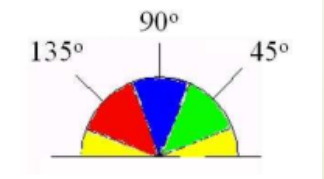


  ### Apply Non-Maximum Surpression:

  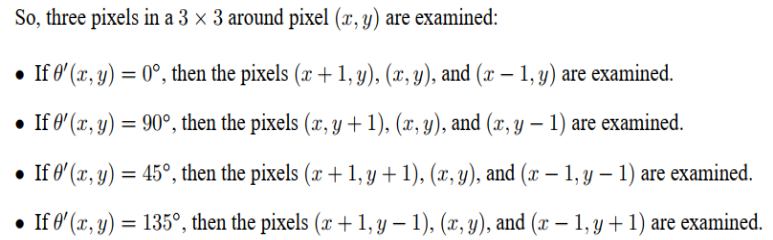


In [27]:
def non_max_suppression(img, theta):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)

    # converting radians to degree
    angle = theta * 180. / np.pi    # max -> 180, min -> -180
    angle[angle < 0] += 180         # max -> 180, min -> 0

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255

            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                r = img[i, j-1]
                q = img[i, j+1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                r = img[i-1, j+1]
                q = img[i+1, j-1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                r = img[i-1, j]
                q = img[i+1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                r = img[i+1, j+1]
                q = img[i-1, j-1]

            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0
    return Z

## 5. **Double Thresholding and hysteresis**:
Double threshold is used to identify strong and weak edges in the image. Pixels with a gradient magnitude above the high threshold are considered strong edges and thus we assign pixel value of 255 to it. Pixels with a gradient magnitude below the low threshold are considered non-edges so they gets pixel value of 0. Pixels with a gradient magnitude between the low and high threshold are considered weak edges. These pixels are only assign pixel value of 255, if they are connected to a strong edge, else assign pixel value of 0 to it, this process is called hysteresis.

In [28]:
def threshold_hysteresis(img: np.ndarray, lowThresholdRatio=0.05, highThresholdRatio=0.09, weak=np.int32(25)):
    '''
    Double threshold and Hysteresis
    '''

    # DOUBLE THRESHOLDING

    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    # zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # HYSTERESIS

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (res[i, j] == weak):
                if (
                    (res[i+1, j-1] == strong) or (res[i+1, j] == strong) or
                    (res[i+1, j+1] == strong) or (res[i, j-1] == strong) or
                    (res[i, j+1] == strong) or (res[i-1, j-1] == strong) or
                    (res[i-1, j] == strong) or (res[i-1, j+1] == strong)
                ):
                    res[i, j] = strong
                else:
                    res[i, j] = 0

    return res

In [29]:
def cannyEdgeDetection(
    image: np.ndarray, sigma: int | float, filter_shape, image_format='rgb',
    lowthreshold: float | int = 0.05, highthreshold: float | int = 0.09
):
    G, theta = sobelEdgeDetection(image, sigma, image_format, filter_shape)
    img = non_max_suppression(G, theta)
    img = threshold_hysteresis(img, lowthreshold, highthreshold)
    return img



# original image

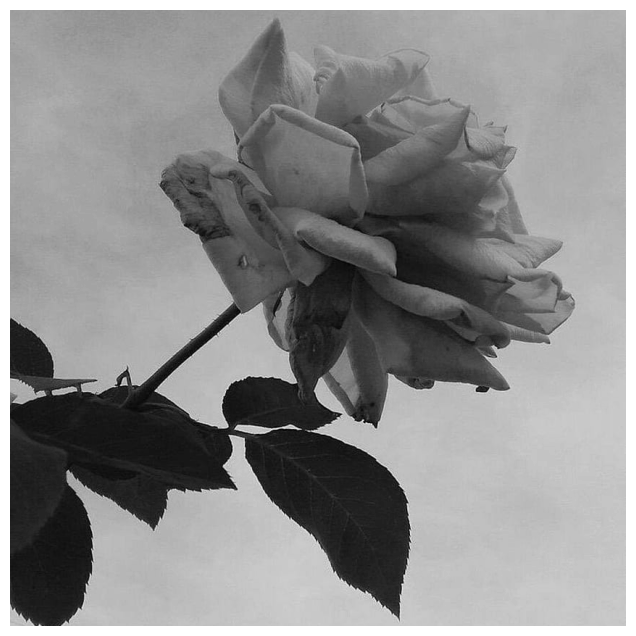

In [53]:
image = cv2.imread('/content/desktop-wallpaper-aesthetic-artsy-iphone-home-screen-cute-artistic.jpg')

# Calculate the dimensions for a square image
min_dimension = min(image.shape[0], image.shape[1])
start_row = (image.shape[0] - min_dimension) // 2
end_row = start_row + min_dimension
start_col = (image.shape[1] - min_dimension) // 2
end_col = start_col + min_dimension

# Crop and resize the image to a square
square_image = image[start_row:end_row, start_col:end_col]

# Convert the square image to grayscale
#gray_image = cv2.cvtColor(square_image, cv2.COLOR_RGB2GRAY)
gray_image=togray(square_image,'rgb')

# Display the squared grayscale image
plt.figure(figsize=(8, 8))
plt.axis('off')  # Turn off axes
plt.imshow(gray_image, cmap='gray')
plt.show()

# Edge-detected image

In [54]:
res = cannyEdgeDetection(square_image, 1.5, (10, 10), 'rgb')

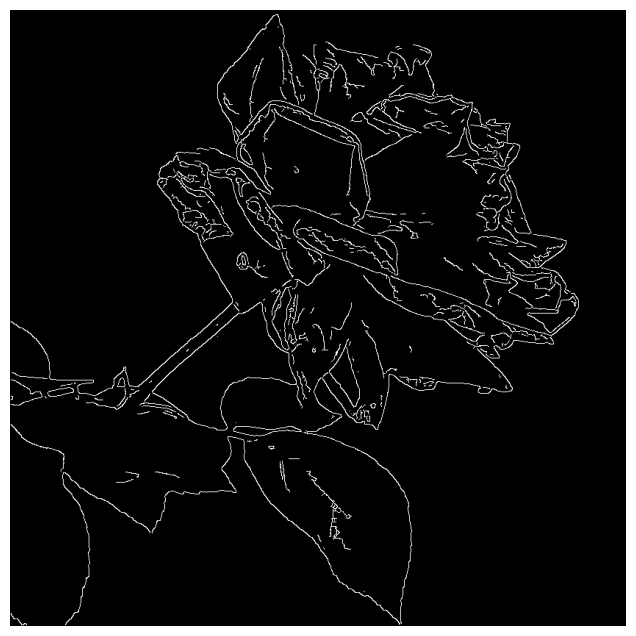

In [55]:
plt.figure(figsize=(8, 8))
plt.axis('off')  # Turn off axes
plt.imshow(res, cmap='gray')
plt.show()